<a href="https://colab.research.google.com/github/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification/blob/main/GBT%5CGBT_ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
# Classical model imports
import math
import urllib
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
import json
from scipy.stats import pointbiserialr
import random

#**Classical Model**
In this section, we implement a classical tree-based machine learning model to serve as a performance baseline for comparison against Large Language Models (LLMs) on a tabular classification task.

TensorFlow Decision Forests (TF-DF) is a library designed for building tree-based models, including Random Forests, Gradient Boosted Trees (GBT), and Classification and Regression Trees (CART).

There is an existing implementation of GBT on a version of our dataset, available on Hugging Face [1] and GitHub [2]. To better understand and adapt this approach to our dataset, we reimplement the method from scratch based on the official Keras example [3].

References:

[Hugging Face: TF Decision Trees](https://huggingface.co/keras-io/TF_Decision_Trees)  

[GitHub: TF-GB-Forest Project](https://github.com/tdubon/TF-GB-Forest/blob/main/README.md)  

[Keras: Classification with TF-DF](https://keras.io/examples/structured_data/classification_with_tfdf/)



### 1. Setup
Installing TensorFlow Decision Forests

In [ ]:
!pip install tensorflow_decision_forests

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf

### 2. Data Pre-Processing

First, we'll track which columns have numerical values and which are categorical. We'll also pay special attention to the target column and weight column.

In [ ]:
# Identify numerical columns (int, float)
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical columns (object, category)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Print the feature names (column names)
print("Numerical Features:", numerical_columns)
print("Categorical Features:", categorical_columns)

Numerical Features: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


In [ ]:
# Define the columns based on the categories you mentioned
TARGET_COLUMN_NAME = "income"  # The column we're predicting
TARGET_LABELS = ["<=50K", ">50K"]  # Treat income as a categorical target variable with these two possible labels.
WEIGHT_COLUMN_NAME = "fnlwgt"  # The weight column (if applicable)

# Numeric features based on the output
NUMERIC_FEATURE_NAMES = [
    'age',
    'fnlwgt',
    'educational-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
]

# Categorical features based on the output
CATEGORICAL_FEATURE_NAMES = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country'
]

Now, we split the data into Train-Test-Val sets

In [ ]:
# Split the data into train and test sets (80% train, 20% test)
temp_train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_data, val_data = train_test_split(temp_train_data, test_size=0.2, random_state=42, shuffle=True)

We'll continue the pre-processing by encoding the target columns so that :
*   '<=50'   becomes   0
*   '>50'    becomes   1

Also, we'll converts categorical features to string in order to ensures TF-DF treats them as categorical


In [ ]:
def prepare_dataframe(df):
    # Convert the target labels from string to integer.
    df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(
        TARGET_LABELS.index
    )
    # Cast the categorical features to string.
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        df[feature_name] = df[feature_name].astype(str)


prepare_dataframe(train_data)
prepare_dataframe(test_data)

Now we will show the shapes of the training and test dataframes

In [ ]:
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (31258, 15)
Test data shape: (9769, 15)
Validation data shape: (7815, 15)


### 3. Model Training & Evaluation
We'll train a **Gradient Boosted Trees (GBT) model** using TensorFlow Decision Forests.  
This model is chosen because:
- It improves performance over standard decision trees.
- It reduces overfitting by sequentially training trees.
- It automatically handles categorical features.

In [ ]:
# Gradient Boosted Trees (GBT) model for classification with configured hyperparameters
model_gbt = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    num_trees=250,              # Number of trees to train
    max_depth=5,                # Maximum tree depth
    min_examples=6,             # Minimum number of examples per leaf
    subsample=0.65,             # Subsampling ratio per tree
    sampling_method="RANDOM",   # Sampling method
    random_seed=42,             # Optional: for reproducibility
    l2_regularization=0.005
)


Use /tmp/tmpo2x___q6 as temporary training directory


The run_experiment() method is responsible loading the train and test datasets, training a given model, and evaluating the trained model.

In [ ]:
def run_experiment(model, train_data, test_data):
    # Check target labels
    print("Unique Target Labels:", train_data[TARGET_COLUMN_NAME].unique())

    # Convert Pandas DataFrame to TensorFlow dataset
    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=TARGET_COLUMN_NAME
    )
    test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_data, label=TARGET_COLUMN_NAME
    )
    val_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        val_data, label=TARGET_COLUMN_NAME
    )

    # Compile model with explicit weighted metrics
    model.compile(metrics=["accuracy"])

    # Train the model with early stopping
    model.fit(train_dataset, validation_data=val_dataset)

    # Evaluate the model
    y_true = test_data[TARGET_COLUMN_NAME].values  # Actual labels
    start_time = time.time()
    y_pred = model_gbt.predict(test_dataset)  # Raw probabilities
    end_time = time.time()
    y_pred_class = (y_pred > 0.5).astype(int)  # Convert to 0 or 1

    inference_time = end_time - start_time

    # Compare actual vs. predicted labels
    correct_predictions = np.sum(y_true == y_pred_class.flatten())
    total_predictions = len(y_true)

    print(f"Correctly Predicted: {correct_predictions}/{total_predictions}")
    print(f"Computed Accuracy: {correct_predictions / total_predictions:.2%}")

    # Calculate metrics
    precision = precision_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)
    accuracy = accuracy_score(y_true, y_pred_class)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")


run_experiment(model_gbt, train_data, test_data)

Unique Target Labels: [0 1]
Reading training dataset...
Training dataset read in 0:00:10.308262. Found 31258 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(7815, shape=(), dtype=int32)
Validation dataset read in 0:00:01.480251. Found 7815 examples.
Training model...
Model trained in 0:00:06.446500
Compiling model...
Model compiled.
10/10 [==============================] - 0s 21ms/step
Correctly Predicted: 8598/9769
Computed Accuracy: 88.01%
Precision: 0.7891
Recall: 0.6668
F1 Score: 0.7228
Accuracy: 0.8801
Inference Time: 0.4622 seconds


Now, we will analyzes which features are most important for the model. This function measures how frequently and how effectively each feature is used across all decision trees, helping to understand and interpret the model's decision-making process.


*   INV_MEAN_MIN_DEPTH: Measures how early a feature is used in the decision trees (closer to the root implies higher importance).

*   SUM_SCORE: Reflects the total contribution of each feature to improving predictions.

*  NUM_AS_ROOT: Counts how often a feature appears as the root of a tree.

*   NUM_NODES: Counts how many times a feature is used in any node (root or internal).





In [ ]:
inspector = model_gbt.make_inspector()
inspector.variable_importances()

{'INV_MEAN_MIN_DEPTH': [("native-country" (4; #10), 0.2582351879338899),
  ("occupation" (4; #11), 0.2571737926873857),
  ("age" (1; #1), 0.24959139503952352),
  ("relationship" (4; #13), 0.24690018178365053),
  ("education" (4; #4), 0.24550447103285186),
  ("capital-gain" (1; #2), 0.24308030832466598),
  ("hours-per-week" (1; #8), 0.23807758887575933),
  ("marital-status" (4; #9), 0.23281335862584704),
  ("capital-loss" (1; #3), 0.2267559570160413),
  ("fnlwgt" (1; #6), 0.2217290773217551),
  ("workclass" (4; #14), 0.2203509505913777),
  ("educational-num" (1; #5), 0.21633040308871765),
  ("race" (4; #12), 0.20600796834545468),
  ("gender" (4; #7), 0.205924445026235)],
 'SUM_SCORE': [("relationship" (4; #13), 3076.621199436282),
  ("capital-gain" (1; #2), 1984.1949931912022),
  ("occupation" (4; #11), 1190.4365277741563),
  ("education" (4; #4), 1021.6334399485968),
  ("marital-status" (4; #9), 985.5364037900363),
  ("capital-loss" (1; #3), 616.3968090704311),
  ("educational-num" (1;

In [ ]:
print(model_gbt.summary())

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (14):
	age
	capital-gain
	capital-loss
	education
	educational-num
	fnlwgt
	gender
	hours-per-week
	marital-status
	native-country
	occupation
	race
	relationship
	workclass

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "native-country"  0.258235 ################
    2.      "occupation"  0.257174 ###############
    3.             "age"  0.249591 #############
    4.    "relationship"  0.246900 ############
    5.       "education"  0.245504 ############
    6.    "capital-gain"  0.243080 ###########
    7.  "hours-per-week"  0.238078 #########
    8.  "marita

10/10 [==============================] - 1s 39ms/step
ROC AUC: 0.9294


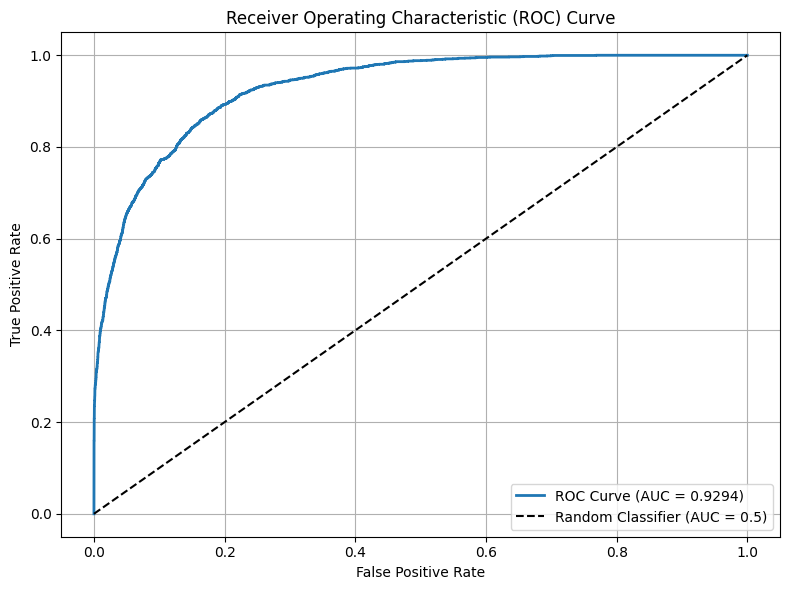

In [ ]:
# 1. Predict probabilities for the positive class using the trained model
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=TARGET_COLUMN_NAME)
y_proba = model_gbt.predict(test_dataset).flatten()

# 2. Get the true binary labels from the test set
y_true = test_data[TARGET_COLUMN_NAME].values

# 3. Compute ROC AUC score
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# 4. Compute ROC curve points (False Positive Rate, True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# 5. Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()